# CNN + GlobalAvgPool 
Based on CNN 107 which got 75% acc on H1 coding len 2000-4000.  
Model: Embed mask, Conv1D, GlobalAvgPool.   

H1 coding len 200-1000.  
Cross validation 5 folds 5 epochs, accuracy mean , F1 mean 


In [12]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-12-29 14:52:48.131204
Python 3.8.16
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [13]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import Flatten
from keras.layers import Attention
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
CFILTERS=64
FILTERSIZE=8
RCELLS=16
DCELLS=8
EPOCHS=5
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=200
MAXLEN=1000   

In [14]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/


In [15]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [16]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
CELL_LINE_NUMBER=1
all_cell_lines = get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 1 = H1.hESC


## Data Load

In [17]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields[0]
                    rci_val = fields[cell_line+1]
                    if rci_val != "nan":
                        # Convert string nan to float(nan)
                        gene_to_rci[gene_id] = float(rci_val)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq
    
loader = DataLoader()
# test it
print(loader.seq_to_kmer_values('AAAA',3))
print(loader.seq_to_kmer_values('CATT',3))
print(loader.seq_to_kmer_values('TTGA',3))
print(loader.seq_to_kmer_values('TTTN',3))
# test it
print(loader.rci_to_label(-0.9))
print(loader.rci_to_label(1.1))

[1, 1]
[20, 16]
[63, 57]
[64, 0]
0
1


In [18]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE_NUMBER)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(allseq))
print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2022-12-29 14:52:50.461184
Load RCI values...
Num RCI: 13000
Example RCI: [('ENSG00000000003', 1.85734), ('ENSG00000000005', 5.88264), ('ENSG00000000419', 2.58954)]
Load genes...
2022-12-29 14:52:50.523858
Load sequence...
2022-12-29 14:52:58.539091
Num IDs: 21792
Example IDs: [('ENSG00000131591', 'ENST00000427787.5'), ('ENSG00000160087', 'ENST00000509720.5'), ('ENSG00000127054', 'ENST00000534345.5'), ('ENSG00000215915', 'ENST00000475091.2')]
Count 10895 ones out of 21792 labels.
Example labels: [0, 1, 0, 0]
Num counts: 21792
Example sequence: [106, 166, 152, 94, 117, 210, 71, 26, 103, 156, 110, 182, 215, 92, 111, 186, 229, 147, 74, 39, 155, 105, 163, 139, 42, 168, 160, 126, 246, 216, 95, 121, 227, 138, 38, 150, 86, 86, 88, 95, 123, 233, 163, 137, 35, 138, 38, 152, 95, 123, 234, 166, 152, 95, 123, 235, 170, 166, 150, 87, 91, 107, 172, 175, 188, 239, 187, 233, 163, 137, 34, 134, 22, 88, 94, 118, 214, 87, 91, 107, 170, 168, 160, 128, 254, 245, 209, 68, 14, 54, 215, 91, 107, 170, 165, 147

## Model

In [19]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    #rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=False) )
    #pool_layer = MaxPooling1D(pool_size=3)
    pool_layer = GlobalAveragePooling1D()
    flat_layer = Flatten()
    den1_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    rnn.add(embed_layer)
    rnn.add(cnn1_layer)
    rnn.add(pool_layer)
    #rnn.add(flat_layer)
    #rnn.add(den1_layer)
    #rnn.add(drop_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [20]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2022-12-29 14:52:59.752838
COMPILE
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 997, 4)            1028      
                                                                 
 conv1d_6 (Conv1D)           (None, 990, 64)           2112      
                                                                 
 global_average_pooling1d_6   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 3,205
Trainable params: 3,205
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [21]:
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,pred_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = pred_threshold # e.g. score>0.5 => class 1
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        for train_index,valid_index in splitter.split(all_genes):
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print('Train sizes',X_train.shape,y_train.shape)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                    validation_data=(X_valid,y_valid) )

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print("Compute valiation accuracy")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

2022-12-29 14:52:59.889490
2022-12-29 14:52:59.889647
splitting
Fold 1
Training example
[ 74  39 154 104 160 127 251 235 171 170 168 158 119 218 103 155 107 170
 166 151  90 104 158 118 214  88  94 118 215  90 104 158 119 219 105 161
 131  11  43 169 161 129   1   3  12  46 184 223 121 225 131   9  34 135
  26 104 160 125 244 207  60 238 182 213  81  67  11  43 171 169 164 142
  54 216  95 122 229 147  75  44 175 186 229 148  78  54 216  94 118 215
  89 100 142  56 223 122 231 153  98 136  31 122 230 150  87  91 107 170
 168 159 122 230 151  89  97 132  13  52 206  54 216  94 118 214  86  87
  91 108 175 185 225 130   6  23  91 107 171 171 170 167 155 106 168 159
 123 234 165 147  73  34 133  17  67   9  35 139  41 162 133  19  76  46
 183 218 102 150  88  95 122 230 152  95 122 230 151  90 102 150  87  91
 105 161 130   6  24  95 121 225 131   9  33 131  11  41 163 138  39 153
  97 130   8  30 118 214  85  83  74  40 160 126 248 222 120 223 122 230
 149  83  74  39 153 100 143  59 236

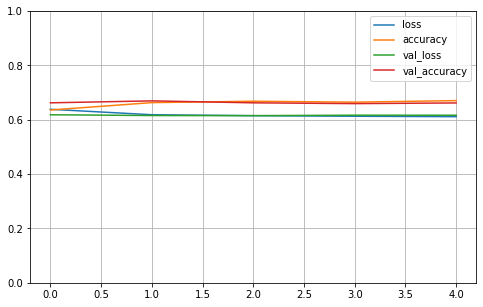

Compute valiation accuracy
2022-12-29 14:53:15.715651
Range of scores: 0.048545536 to 0.96818227
Predicted zeros and ones 2505 1935
Accuracy: 66.17% Precision: 68.68% Recall: 59.73% F1: 63.89%
2022-12-29 14:53:16.130141
Fold 2
Training example
[ 74  39 154 104 160 127 251 235 171 170 168 158 119 218 103 155 107 170
 166 151  90 104 158 118 214  88  94 118 215  90 104 158 119 219 105 161
 131  11  43 169 161 129   1   3  12  46 184 223 121 225 131   9  34 135
  26 104 160 125 244 207  60 238 182 213  81  67  11  43 171 169 164 142
  54 216  95 122 229 147  75  44 175 186 229 148  78  54 216  94 118 215
  89 100 142  56 223 122 231 153  98 136  31 122 230 150  87  91 107 170
 168 159 122 230 151  89  97 132  13  52 206  54 216  94 118 214  86  87
  91 108 175 185 225 130   6  23  91 107 171 171 170 167 155 106 168 159
 123 234 165 147  73  34 133  17  67   9  35 139  41 162 133  19  76  46
 183 218 102 150  88  95 122 230 152  95 122 230 151  90 102 150  87  91
 105 161 130   6  24  95 1

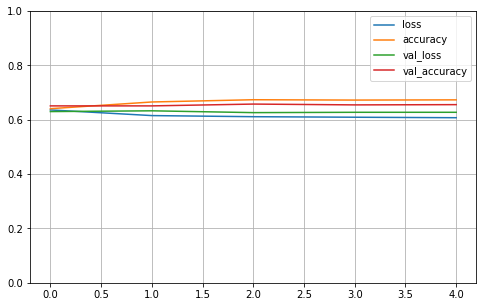

Compute valiation accuracy
2022-12-29 14:53:38.769238
Range of scores: 0.013677283 to 0.9655476
Predicted zeros and ones 2162 2192
Accuracy: 65.55% Precision: 64.69% Recall: 66.14% F1: 65.41%
2022-12-29 14:53:39.185085
Fold 3
Training example
[ 74  39 154 104 160 127 251 235 171 170 168 158 119 218 103 155 107 170
 166 151  90 104 158 118 214  88  94 118 215  90 104 158 119 219 105 161
 131  11  43 169 161 129   1   3  12  46 184 223 121 225 131   9  34 135
  26 104 160 125 244 207  60 238 182 213  81  67  11  43 171 169 164 142
  54 216  95 122 229 147  75  44 175 186 229 148  78  54 216  94 118 215
  89 100 142  56 223 122 231 153  98 136  31 122 230 150  87  91 107 170
 168 159 122 230 151  89  97 132  13  52 206  54 216  94 118 214  86  87
  91 108 175 185 225 130   6  23  91 107 171 171 170 167 155 106 168 159
 123 234 165 147  73  34 133  17  67   9  35 139  41 162 133  19  76  46
 183 218 102 150  88  95 122 230 152  95 122 230 151  90 102 150  87  91
 105 161 130   6  24  95 12

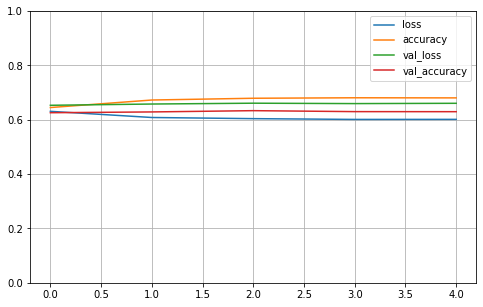

Compute valiation accuracy
2022-12-29 14:54:01.779564
Range of scores: 0.014931135 to 0.9664198
Predicted zeros and ones 2480 2009
Accuracy: 62.95% Precision: 63.71% Recall: 57.81% F1: 60.62%
2022-12-29 14:54:02.618366
Fold 4
Training example
[ 74  39 154 104 160 127 251 235 171 170 168 158 119 218 103 155 107 170
 166 151  90 104 158 118 214  88  94 118 215  90 104 158 119 219 105 161
 131  11  43 169 161 129   1   3  12  46 184 223 121 225 131   9  34 135
  26 104 160 125 244 207  60 238 182 213  81  67  11  43 171 169 164 142
  54 216  95 122 229 147  75  44 175 186 229 148  78  54 216  94 118 215
  89 100 142  56 223 122 231 153  98 136  31 122 230 150  87  91 107 170
 168 159 122 230 151  89  97 132  13  52 206  54 216  94 118 214  86  87
  91 108 175 185 225 130   6  23  91 107 171 171 170 167 155 106 168 159
 123 234 165 147  73  34 133  17  67   9  35 139  41 162 133  19  76  46
 183 218 102 150  88  95 122 230 152  95 122 230 151  90 102 150  87  91
 105 161 130   6  24  95 12

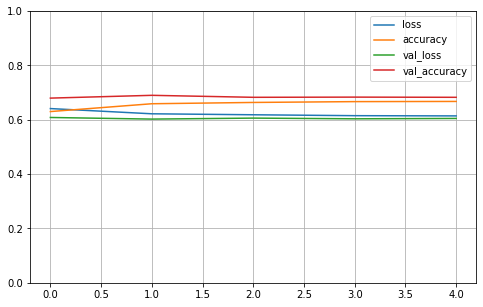

Compute valiation accuracy
2022-12-29 14:54:18.526218
Range of scores: 0.030223662 to 0.96952504
Predicted zeros and ones 2043 2347
Accuracy: 68.25% Precision: 66.85% Recall: 71.81% F1: 69.24%
2022-12-29 14:54:18.938887
Fold 5
Training example
[155 107 170 166 152  95 123 233 163 138  38 151  91 107 169 164 142  54
 215  90 102 150  88  93 115 203  43 171 170 168 158 119 219 105 164 142
  55 218 102 151  90 103 154 103 154 104 158 119 218 102 151  90 104 158
 119 218 102 150  87  90 102 149  83  74  38 150  87  90 102 150  87  92
 111 187 236 174 182 215  92 111 187 234 167 155 106 167 154 103 154 104
 158 118 213  82  70  22  87  91 106 165 146  71  27 107 171 169 163 139
  42 167 154 103 155 107 171 170 167 154 101 146  70  21  84  79  59 234
 166 151  90 101 147  73  34 133  18  71  26 102 151  91 107 171 169 161
 129   2   6  23  89  99 138  39 154 102 152  94 119 218 102 151  89 100
 143  59 234 165 147  75  41 163 138  39 154 102 151  91 106 166 149  83
  74  39 154 102 149  83  

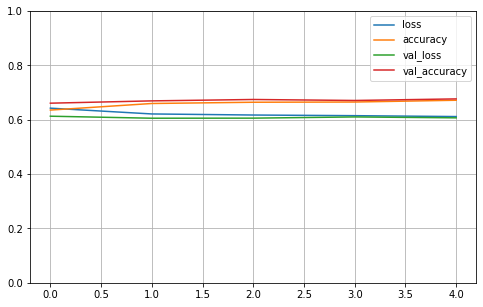

Compute valiation accuracy
2022-12-29 14:54:35.027600
Range of scores: 0.0353733 to 0.9701653
Predicted zeros and ones 1900 2219
Accuracy: 67.66% Precision: 67.91% Recall: 70.85% F1: 69.35%
2022-12-29 14:54:35.346020

Cross validation 5 folds 5 epochs
 accuracy mean 66.12% +/- 1.86
 precision mean 66.37% +/- 1.89
 recall mean 65.27% +/- 5.67
 F1 mean 65.70% +/- 3.32
2022-12-29 14:54:35.348324


In [22]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(datetime.now())